Advanced Lane Finding
===

#### Building an advanced lane lines finding algorithm

The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

## Calibration the camera with OpenCV
Extract object points and image points for camera calibration

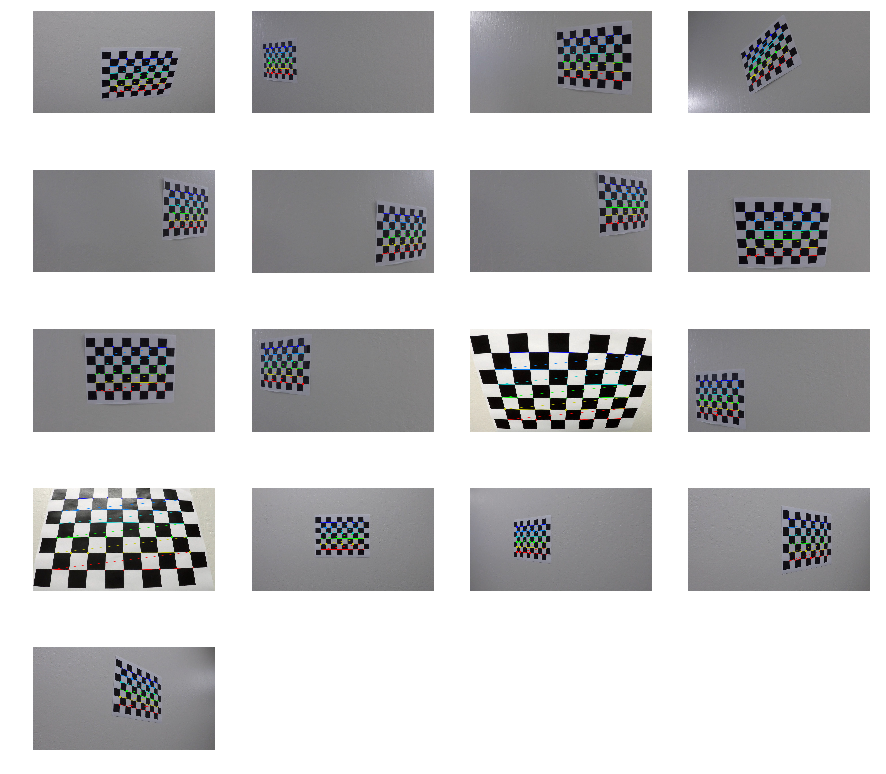

In [69]:
def do_camera_calibration():
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3D points in real world space 
    imgpoints = [] # 2D points in image plane
    sample_images=[] # for display in the notebook
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Make a list of calibration images
    images = glob.glob('C:\\data\\camera_cal\\cal*')
    #images = glob.glob('C:\data\\calibration_wide\GO*.jpg')
    
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        
        # If found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            #draw lines on the cheesboard
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            sample_images.append(img)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    #save the calibration data in a pickle file to use later
    camera_cal_val = "camera_calibration.p" 
    output = open(camera_cal_val, 'wb')

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, output)
    output.close()
    
    plt.figure(figsize=(15, 20))
    for i in range(len(sample_images)):
       # Displaying the images 
        plt.subplot(7, 4, i+1)
        plt.imshow(sample_images[i]) 
        plt.axis('off')
    
do_camera_calibration()


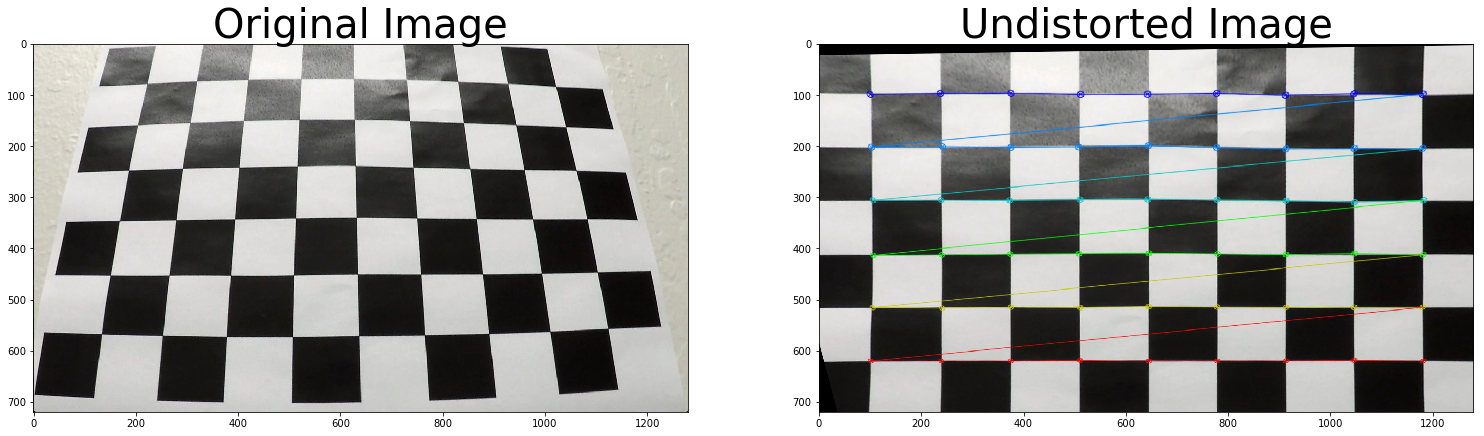

In [76]:
# Return the saved object points and image points 
def get_camera_calibration():
    dist_pickle = pickle.load( open( "camera_calibration.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    return mtx, dist

# Takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, mtx, dist):
    img_size = (img.shape[1], img.shape[0])
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# A function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients, and return the undistort image with chessboard corners
def corners_unwarp(img, mtx, dist):
    nx, ny = 9, 6
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    # Search for corners in the grayscaled image
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        # If we found corners, draw them
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # This should be chosen to present the result at the proper aspect ratio
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)
    # Return the resulting image and matrix
    return warped

# Read in the test image
img = mpimg.imread('C:\\data\\camera_cal\\test.jpg')

mtx, dist = get_camera_calibration()
undistorted = corners_unwarp(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

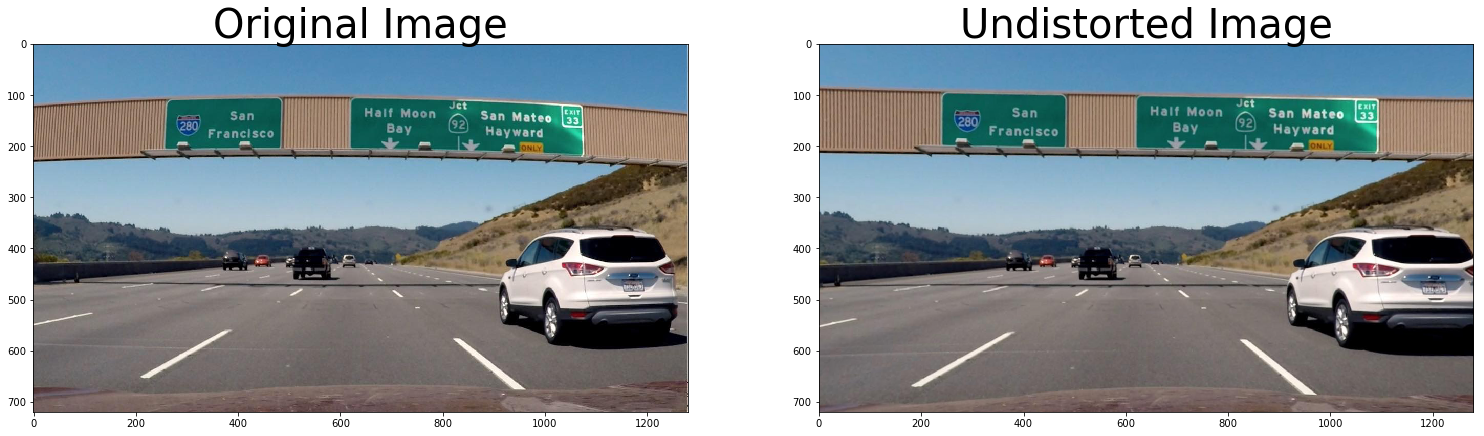

In [77]:
#Here is an example of the distortion correction on an image from the car camera:
    
img = mpimg.imread('C:\\data\\distortion\\vehicles.png')

mtx, dist = get_camera_calibration()
undistorted = cal_undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

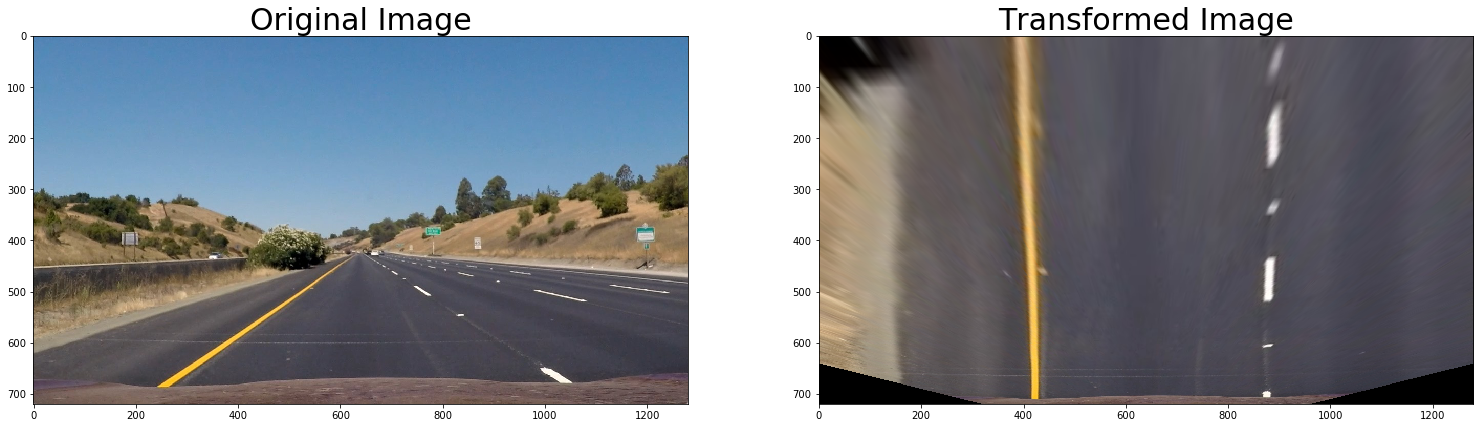

In [81]:
# perspective transform on undistorted images
def perspective_transform(image):
    shape_x = image.shape[0]
    shape_y = image.shape[1]
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    src = np.float32([[(.55*shape_y, 0.63*shape_x), (shape_y,shape_x),(0,shape_x),(.45*shape_y, 0.63*shape_x)]])
    dst = np.float32([[0.75*shape_y,0],[0.75*shape_y,shape_x], [0.25*shape_y,shape_x],[0.25*shape_y,0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    newwarp = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags = cv2.INTER_LINEAR) 
    return newwarp, Minv

image = mpimg.imread('C:\\data\\distortion\\straight_lines1.jpg')
newwarp, Minv = perspective_transform(image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(newwarp)
ax2.set_title('Transformed Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [2]:
# Calculate directional gradient
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobelx = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_binary = np.zeros_like(scaled_sobel)
    sobel_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sobel_binary

# Calculate gradient magnitude
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

# Calculate gradient direction
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the direction of the gradient using the absolute value of the x and y gradients
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    # 4) Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output.astype(np.uint8)


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# getting a warped binary image
def sliding_window(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # number of sliding windows
    nwindows = 9
    # height of each window
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    #---------------------------------------------------------
    #check for any lanes that are not detected in this current frame then use the history
    left_lane.detected = False if (leftx.size < nwindows/2) else True
    right_lane.detected = False if (rightx.size < nwindows/2) else True

    # if lane is detected then try to fit the poly
    if left_lane.detected == True & right_lane.detected == True:
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        left_lane.best_fit = np.vstack([left_lane.best_fit,left_fit])
        left_lane.best_fit[0] = left_fit
        left_lane.best_fit = np.average(left_lane.best_fit[-left_lane.smoothen_nframes:], axis = 0)
        
        right_fit = np.polyfit(righty, rightx, 2)
        right_lane.best_fit = np.vstack([right_lane.best_fit,right_fit])
        right_lane.best_fit[0] = right_fit
        right_lane.best_fit = np.average(right_lane.best_fit[-right_lane.smoothen_nframes:], axis = 0)
        #print ("saved best fit")
    else: 
        #use the history avg values 
        left_fit = left_lane.best_fit
        right_fit = right_lane.best_fit
        #print ("used previous best fit")
        
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #------------------------------------------------

    #Take the average of the last n frames   
    if left_lane.first_frame == True:
        left_lane.first_frame = False
        left_lane.bestx = np.vstack([left_lane.bestx,left_fitx])
        left_lane.bestx[0] = left_fitx
        #print ("Inside first frame")
    
    if ((left_fitx[0] > right_fitx[0]) | (abs(left_fitx[0] - right_fitx[0])<350) | (abs(left_fitx[0] - right_fitx[0])>700) | 
                   (left_fitx[0] > 800 )):
        left_lane.bestx = np.vstack([left_lane.bestx,left_lane.bestx])  
        #print ("Skip lane left")
    else:
        left_lane.bestx = np.vstack([left_lane.bestx,left_fitx])
        #print ("read lane left")
        
    left_lane.bestx = np.average(left_lane.bestx[-left_lane.smoothen_nframes:], axis = 0)
    
    if right_lane.first_frame == True:
        right_lane.first_frame = False
        right_lane.bestx = np.vstack([right_lane.bestx,right_fitx])
        right_lane.bestx[0] = right_fitx
        #print ("Inside first frame")
    
    if ((left_fitx[0] > right_fitx[0]) | (abs(left_fitx[0] - right_fitx[0])<350) | (abs(left_fitx[0] - right_fitx[0])>700) |
                      (right_fitx[0] > 1200)):
        right_lane.bestx = np.vstack([right_lane.bestx,right_lane.bestx])
        #print ("Skip lane right")
    else:
        right_lane.bestx = np.vstack([right_lane.bestx,right_fitx])
        #print ("read lane right")
    
    right_lane.bestx = np.average(right_lane.bestx[-right_lane.smoothen_nframes:], axis = 0)
    
    #------------------------------------------------
    '''
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    plt.figure(figsize=(15, 8))
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.imshow(out_img)
    '''
    return (out_img, (left_lane_inds, right_lane_inds), ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty)

In [4]:
def generate_polygon(out_img, lane_inds, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty):
    window_img = np.zeros_like(out_img)
    margin = 10
    
    left_lane_inds = lane_inds[0]
    right_lane_inds = lane_inds[1]
    
    nonzero = out_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 255]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 0, 255]
    # Generate a polygon to illustrate the SMOOTHENED FIT
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_lane.bestx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_lane.bestx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_lane.bestx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_lane.bestx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 1, 0)
    
    # Generate a polygon to illustrate the CURRENT FRAME FIT
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,0, 255))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,0, 255))
    result = cv2.addWeighted(out_img, 1, window_img, 1, 0)
    
    #if the lane was detectded then calculate the curvatire or use the history
    if (leftx.size > 2 | rightx.size > 2) :
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters and dist from centre
        lane_centre = (left_fitx[-1] + right_fitx[-1])/2.0
        camera_centre = result.shape[1]/2.0

        dist_centre_val = (lane_centre - camera_centre)*3.7/700
        avg_cur = (right_curverad+left_curverad)/2.0
        
        left_lane.line_base_pos = np.vstack([left_lane.line_base_pos,dist_centre_val])
        left_lane.line_base_pos[0] = dist_centre_val
        left_lane.line_base_pos = np.average(left_lane.line_base_pos[-left_lane.smoothen_nframes:], axis = 0)
        
        left_lane.radius_of_curvature = np.vstack([left_lane.radius_of_curvature,avg_cur])
        left_lane.radius_of_curvature[0] = avg_cur
        left_lane.radius_of_curvature = np.average(left_lane.radius_of_curvature[-left_lane.smoothen_nframes:], axis = 0)
        
    #print (avg_cur, dist_centre_val)
    # else use the history curvature
    else:
        dist_centre_val = left_lane.line_base_pos
        avg_cur = left_lane.radius_of_curvature
    
    #reset the lane detected to false for the next frame 
    left_lane.detected == False
    right_lane.detected == False
    return result, left_lane.bestx, right_lane.bestx, ploty, left_lane.radius_of_curvature, left_lane.line_base_pos


Skip the sliding windows step once we know where the lines are.
In the next frame of video we don't need to do a blind search again, but instead we can just search in a margin around the previous line position.

The green shaded area in the example image below shows where we searched for the lines in the last time. So, once we know where the lines are in one frame of video, we can do a highly targeted search for them in the next frame. This is equivalent to using a customized region of interest for each frame of video, and should help us track the lanes through sharp curves and tricky conditions. In case we lose track of the lines, we can go back to the sliding windows search to rediscover them.

In [5]:
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [6]:
global left_lane 
global right_lane

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = np.zeros(720)
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = np.zeros(3)  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = np.zeros(1)
        #distance in meters of vehicle center from the line
        self.line_base_pos = np.zeros(1)
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #smoothen the n frames 
        self.smoothen_nframes = 10
        #first frame 
        self.first_frame = True
        
left_lane = Line()
right_lane = Line()

In [8]:
%matplotlib inline

def thresholding(image):
    
    sobel_x_thresh=(211,255)
    sobel_y_thresh=(0,25)
    magnitude_thresh=(150,255)
    dir_thresh=(0.7,1.3)
    s_thres=(113,255)
    v_thres=(235,255)
    sobel_kernel = 15
    adp_thresh = 250
    y_size = image.shape[0]
    x_size = image.shape[1]
    mask_trapeze = np.array([[(.6*x_size, 0.55*y_size), (x_size,y_size), (0,y_size),(.45*x_size, 0.55*y_size)]], dtype=np.int32)
    
    # Convert to HLS color space and set saturation channel
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hls[:,:,2].astype(np.uint8)
    
    # Convert to HSV color space and set value channel
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV).astype(np.float)
    v_channel = hls[:,:,2].astype(np.uint8)
    
    #threshold grad
    gradx = abs_sobel_thresh(v_channel, orient='x', sobel_kernel=sobel_kernel, thresh=sobel_x_thresh)
    grady = abs_sobel_thresh(v_channel, orient='y', sobel_kernel=sobel_kernel, thresh=sobel_y_thresh)
    mag_binary = mag_thresh(v_channel, sobel_kernel=sobel_kernel, mag_thresh=magnitude_thresh)
    dir_binary = dir_threshold(v_channel, sobel_kernel=sobel_kernel, thresh=dir_thresh)
    combined_grad = np.zeros_like(gradx)
    combined_grad[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Threshold color channel for yellow lanes
    s_binary = np.zeros_like(s_channel).astype(np.uint8)
    s_binary[(s_channel > s_thres[0]) & (s_channel <= s_thres[1])] = 1
    v_binary = np.zeros_like(v_channel).astype(np.uint8)
    v_binary[(v_channel > v_thres[0]) & (v_channel <= v_thres[1])] = 1
    combined_yellow = ((s_binary == 1) | (v_binary == 1)).astype(np.uint8)
    
    # Threshold color channel for white lanes
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    img_hist = cv2.equalizeHist(gray)
    ret, thrs = cv2.threshold(img_hist, thresh=adp_thresh, maxval=255, type=cv2.THRESH_BINARY)
    adp = thrs/255
    
    color_binary = np.zeros_like(gradx)
    color_binary[(combined_grad == 1) | (combined_yellow == 1) | (adp == 1)] = 1
    color_binary = np.dstack(( color_binary, color_binary, color_binary)).astype(np.float32)
    
    #region of interest is applied here 
    color_binary = region_of_interest(color_binary.astype(np.uint8), mask_trapeze)
    
    #plt.imshow(color_binary*255, cmap = "gray")
    return color_binary.astype(np.float32), combined_grad, combined_yellow

In [9]:
%matplotlib inline

def draw_on_original(warped, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(warped).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    color_warp = np.zeros_like(warped).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane with low confidence region (red)
    cv2.fillPoly(color_warp, np.int_([pts]), (255, 0, 0))
    
    #confidence region in green
    pts_left = np.array([np.transpose(np.vstack([left_fitx[400:], ploty[400:]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx[400:], ploty[400:]])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(warped, 1, newwarp, 0.4, 0)
    #plt.imshow(result)

    return result

In [10]:
%matplotlib inline

def pipeline(img):
    verbose = 0
    
    #undistor the image
    mtx, dist = camera_calibration()
    undist = cal_undistort(img, mtx, dist)
    #undist = cv2.undistort(img, mtx, dist, None, mtx)
    #plt.imshow(undist)
    
    #apply the thresholding operation
    thresh_combined, grad_th, col_th = thresholding(undist)
    
    #Perspective transformation
    perspective, Minv = perspective_transform(thresh_combined)

    perspective = cv2.cvtColor(perspective, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    #plt.imshow(perspective, cmap='gray')

    #pass the perspective image to the lane fitting stage
    out_img, lane_inds, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty = sliding_window(perspective)
#    print(left_lane, right_lane, lane_inds)
    
    slides_pers, left_fitx, right_fitx, ploty, avg_cur, dist_centre_val = generate_polygon(out_img, lane_inds, ploty, left_fitx, right_fitx, leftx, lefty, rightx, righty)
   
    #draw the detected lanes on the original image 
    mapped_lane = draw_on_original(undist, left_fitx, right_fitx, ploty, Minv)
    #plt.imshow(mapped_lane)
    
    #font and text for drawing the offset and curvature 
    curvature = "Estimated lane curvature %.2fm" % (avg_cur)
    dist_centre = "Estimated offset from lane center %.2fm" % (dist_centre_val)
    font = cv2.FONT_HERSHEY_COMPLEX
    
    # using cv2 for drawing text/images in diagnostic pipeline.
    if verbose == 1:
        middlepanel = np.zeros((120, 900, 3), dtype=np.uint8)
        l1 = np.zeros((50, 50, 3), dtype=np.uint8)
        l2 = np.zeros((50, 50, 3), dtype=np.uint8)
        l3 = np.zeros((50, 50, 3), dtype=np.uint8)
        l4 = np.zeros((50, 50, 3), dtype=np.uint8)
        l5 = np.zeros((50, 50, 3), dtype=np.uint8)
        l6 = np.zeros((50, 50, 3), dtype=np.uint8)
        l7 = np.zeros((50, 50, 3), dtype=np.uint8)
        legend = np.zeros((240, 1200, 3), dtype=np.uint8)

        cv2.putText(middlepanel, curvature, (30, 60), font, 1, (255,255,255), 2)
        cv2.putText(middlepanel, dist_centre, (30, 90), font, 1, (255,255,255), 2)
        cv2.putText(l1,"1", (15, 35), font, 1, (255,255,0), 2)
        cv2.putText(l2,"2", (15, 30), font, 1, (255,255,0), 2)
        cv2.putText(l3,"3", (15, 30), font, 1, (255,255,0), 2)
        cv2.putText(l4,"4", (15, 30), font, 1, (255,255,0), 2)
        cv2.putText(l5,"5", (15, 30), font, 1, (255,255,0), 2)
        cv2.putText(l6,"6", (15, 30), font, 1, (255,255,0), 2)
        cv2.putText(l7,"7", (15, 30), font, 1, (255,255,0), 2)
        text = "1-Detected Lanes, 2-Color Threshold\n3-Gradient Threshold, 4-Thresholding operations combined\n5-Perspective Transformation, 6-Original Frame\n7-Mapping Polynomials, Blue line-current frame polynomial fit,\nGreen line-smoothened polynomial fit, Pink - Lane pixels"

        y0, dy = 50, 40
        for i, line in enumerate(text.split('\n')):
            y = y0 + i*dy
            cv2.putText(legend, line, (50, y ), font, 1, (255,255,255),2)

        diagScreen = np.zeros((1080, 1920, 3), dtype=np.uint8)
        #2
        diagScreen[0:360, 1200:1560] = cv2.resize(np.dstack((col_th*255,col_th*255, col_th*255)), (360,360), interpolation=cv2.INTER_AREA) 
        #3
        diagScreen[0:360, 1560:1920] = cv2.resize(np.dstack((grad_th*255,grad_th*255,grad_th*255)), (360,360), interpolation=cv2.INTER_AREA) 
        #4
        diagScreen[360:720, 1200:1560] = cv2.resize(thresh_combined*255, (360,360), interpolation=cv2.INTER_AREA) 
        #5
        diagScreen[360:720,1560:1920] = cv2.resize(np.dstack((perspective*255, perspective*255, perspective*255)), (360,360), interpolation=cv2.INTER_AREA) 
        #7
        diagScreen[720:1080,1560:1920] = cv2.resize(slides_pers, (360,360), interpolation=cv2.INTER_AREA) 
        #6
        diagScreen[720:1080,1200:1560] = cv2.resize(img, (360,360), interpolation=cv2.INTER_AREA) 
        #1
        diagScreen[0:720, 0:1200] = cv2.resize(mapped_lane, (1200,720), interpolation=cv2.INTER_AREA) 

        #radii,offset and legend here
        diagScreen[720:840, 0:900] = middlepanel
        diagScreen[0:50, 0:50] = l1
        diagScreen[0:50, 1200: 1250] = l2
        diagScreen[0:50, 1560:1610] = l3
        diagScreen[720:770, 1560:1610] = l7
        diagScreen[360:410, 1560:1610] = l5
        diagScreen[720:770, 1200:1250] = l6
        diagScreen[360:410, 1200:1250] = l4
        diagScreen[840:1080, 0:1200] = legend
        #if diagnosis then return this image 
        return diagScreen
    #else return the original mapped imaged with the curvature and offset drawn
    cv2.putText(mapped_lane, curvature, (30, 60), font, 1.2, (255,0,0), 2)
    cv2.putText(mapped_lane, dist_centre, (30, 120), font, 1.2, (255,0,0), 2)
    return mapped_lane

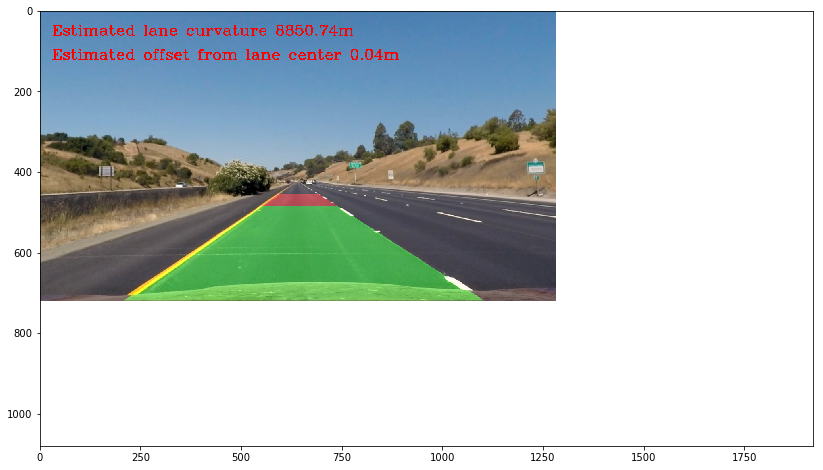

In [48]:
%matplotlib inline
image = mpimg.imread('C:\\data\\distortion\\straight_lines1.jpg')
mapped_lane = pipeline(image)

plt.figure(figsize=(15, 8))
plt.xlim(0, 1920)
plt.ylim(1080, 0)
plt.imshow(mapped_lane)

In [12]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
'''
white_output = 'C:\\Users\\swillin\\Documents\\Private\\courses\\Driver\\projects\\advanced_lane_finding\\test_videos_output\\project_video.mp4'
clip1 = VideoFileClip("C:\\Users\\swillin\\Documents\\Private\\courses\\Driver\\projects\\advanced_lane_finding\\test_videos\\project_video.mp4")
white_clip = clip1.fl_image(pipeline).subclip(1,3) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
'''

'\nwhite_output = \'C:\\Users\\swillin\\Documents\\Private\\courses\\Driver\\projects\\advanced_lane_finding\\test_videos_output\\project_video.mp4\'\nclip1 = VideoFileClip("C:\\Users\\swillin\\Documents\\Private\\courses\\Driver\\projects\\advanced_lane_finding\\test_videos\\project_video.mp4")\nwhite_clip = clip1.fl_image(pipeline).subclip(1,3) #NOTE: this function expects color images!!\n%time white_clip.write_videofile(white_output, audio=False)\n'